# Diagnoza niewydolności serca

Celem projektu jest zbudowanie i porównanie kilku modeli diagnozy niewydolności serca na podstawie [zbioru danych](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction), będącego połączeniem pięciu innych zbioru danych udostępnionych przez UCI Machine Learning Repository.

Plan pracy:
- proces przetwarzania danych
- proces modelowania (znajdowania optymalnych parametrów)
- porównanie kilku modeli
- wizualizacja wyników
- podsumowanie pracy

In [984]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [985]:
df = pd.read_csv('data/heart.csv')

Opis kolumn:
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

# Przetwarzanie danych

In [986]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             916 non-null    float64
 1   Sex             918 non-null    object 
 2   ChestPainType   913 non-null    object 
 3   RestingBP       915 non-null    float64
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      916 non-null    object 
 7   MaxHR           912 non-null    float64
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         916 non-null    float64
 10  ST_Slope        917 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 86.2+ KB


In [987]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40.0,M,ATA,140.0,289,0,Normal,172.0,N,0.0,Up,0
1,49.0,F,NAP,160.0,180,0,Normal,156.0,N,1.0,Flat,1
2,37.0,M,ATA,130.0,283,0,ST,98.0,N,0.0,Up,0
3,48.0,F,ASY,138.0,214,0,Normal,108.0,Y,1.5,Flat,1
4,54.0,M,NAP,150.0,195,0,Normal,122.0,N,0.0,Up,0
5,39.0,M,NAP,120.0,339,0,Normal,170.0,N,0.0,Up,0
6,45.0,F,ATA,130.0,237,0,Normal,170.0,N,0.0,Up,0
7,54.0,M,ATA,110.0,208,0,Normal,142.0,N,0.0,Up,0
8,37.0,M,ASY,140.0,207,0,Normal,130.0,Y,1.5,Flat,1
9,48.0,F,ATA,120.0,284,0,Normal,120.0,N,0.0,Up,0


Zobaczmy, czy mamy jakieś missing values w naszym zbiorze danych.

In [988]:
df.isna().sum()

Age               2
Sex               0
ChestPainType     5
RestingBP         3
Cholesterol       0
FastingBS         0
RestingECG        2
MaxHR             6
ExerciseAngina    0
Oldpeak           2
ST_Slope          1
HeartDisease      0
dtype: int64

Mamy więc brakujące pozycje w kolumnach ChestPainType, RestingBP, Cholesterol, FastingBS, MaxHR, ExerciseAngina i ST_Slope. Zajmiemy się nimi później korzystając z pipeline.

Przjrzyjmy się histogramom naszych danych:

Age
Sex
ChestPainType
RestingBP
Cholesterol
FastingBS
RestingECG
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
HeartDisease


C:\Users\HP\AppData\Local\Temp\ipykernel_22676\934938843.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


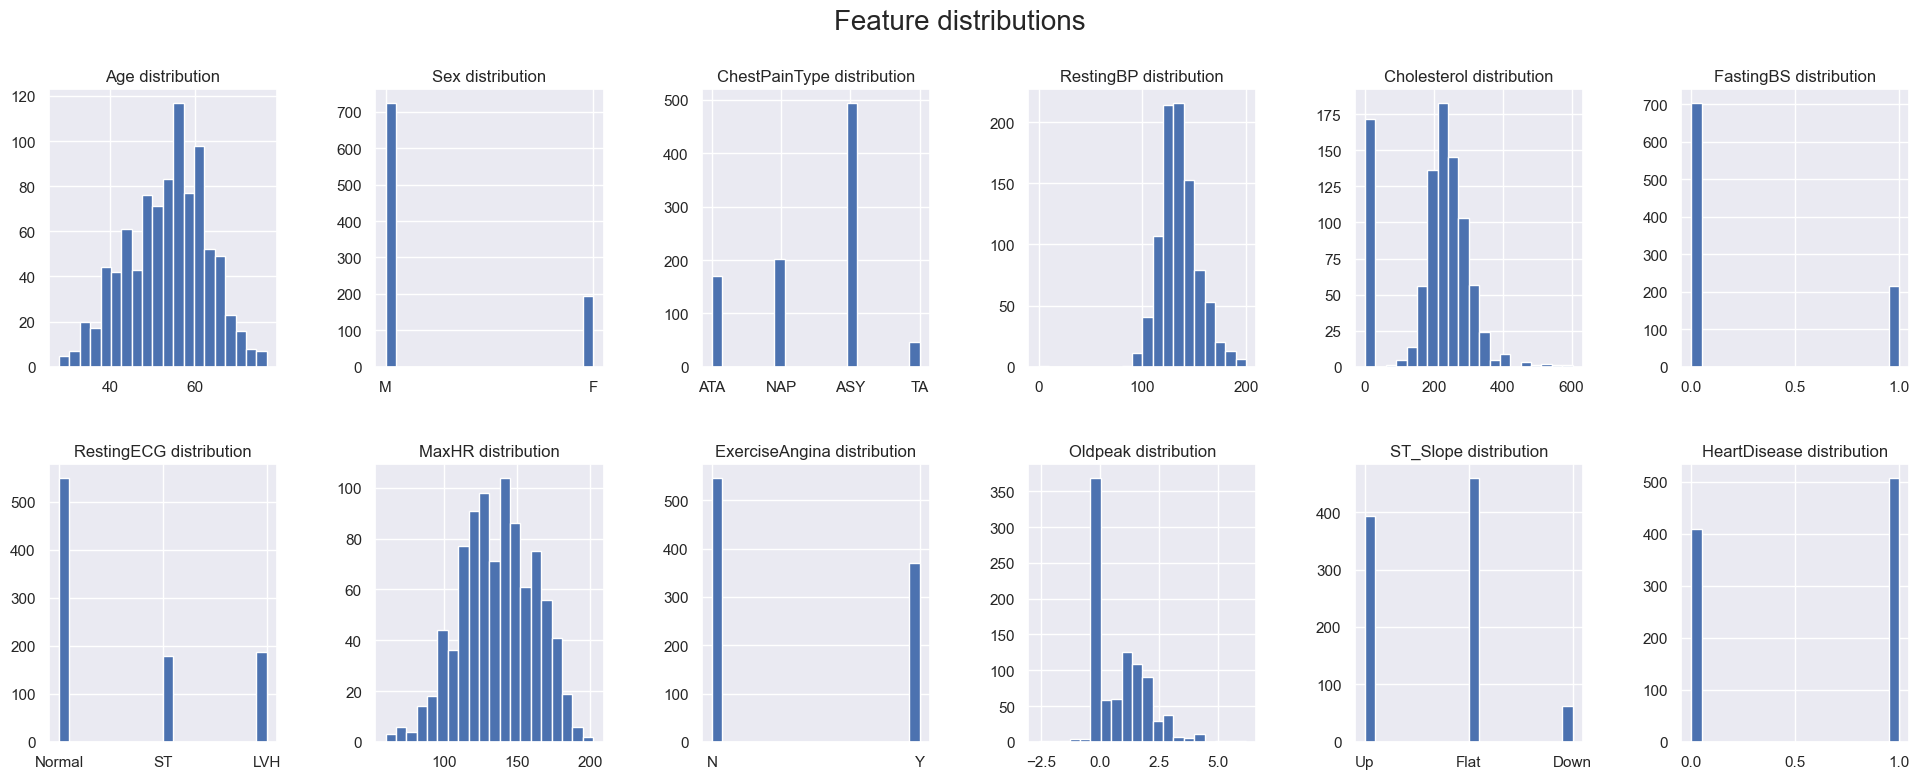

In [989]:

fig, axs = plt.subplots(2, 6, figsize=(20, 8))
i = 0
j = 0
for feature in list(df.columns):
  print(feature)
  df[feature].hist(bins=20, ax=axs[i,j])
  axs[i,j].set_title(feature + " distribution")
  j = j + 1
  if j == 6:
    i = i + 1
    j = 0  

fig.tight_layout(pad=3.0)
fig.suptitle("Feature distributions", fontsize=20, verticalalignment='bottom')
fig.show()

Teraz zobaczmy korelację kolumn.

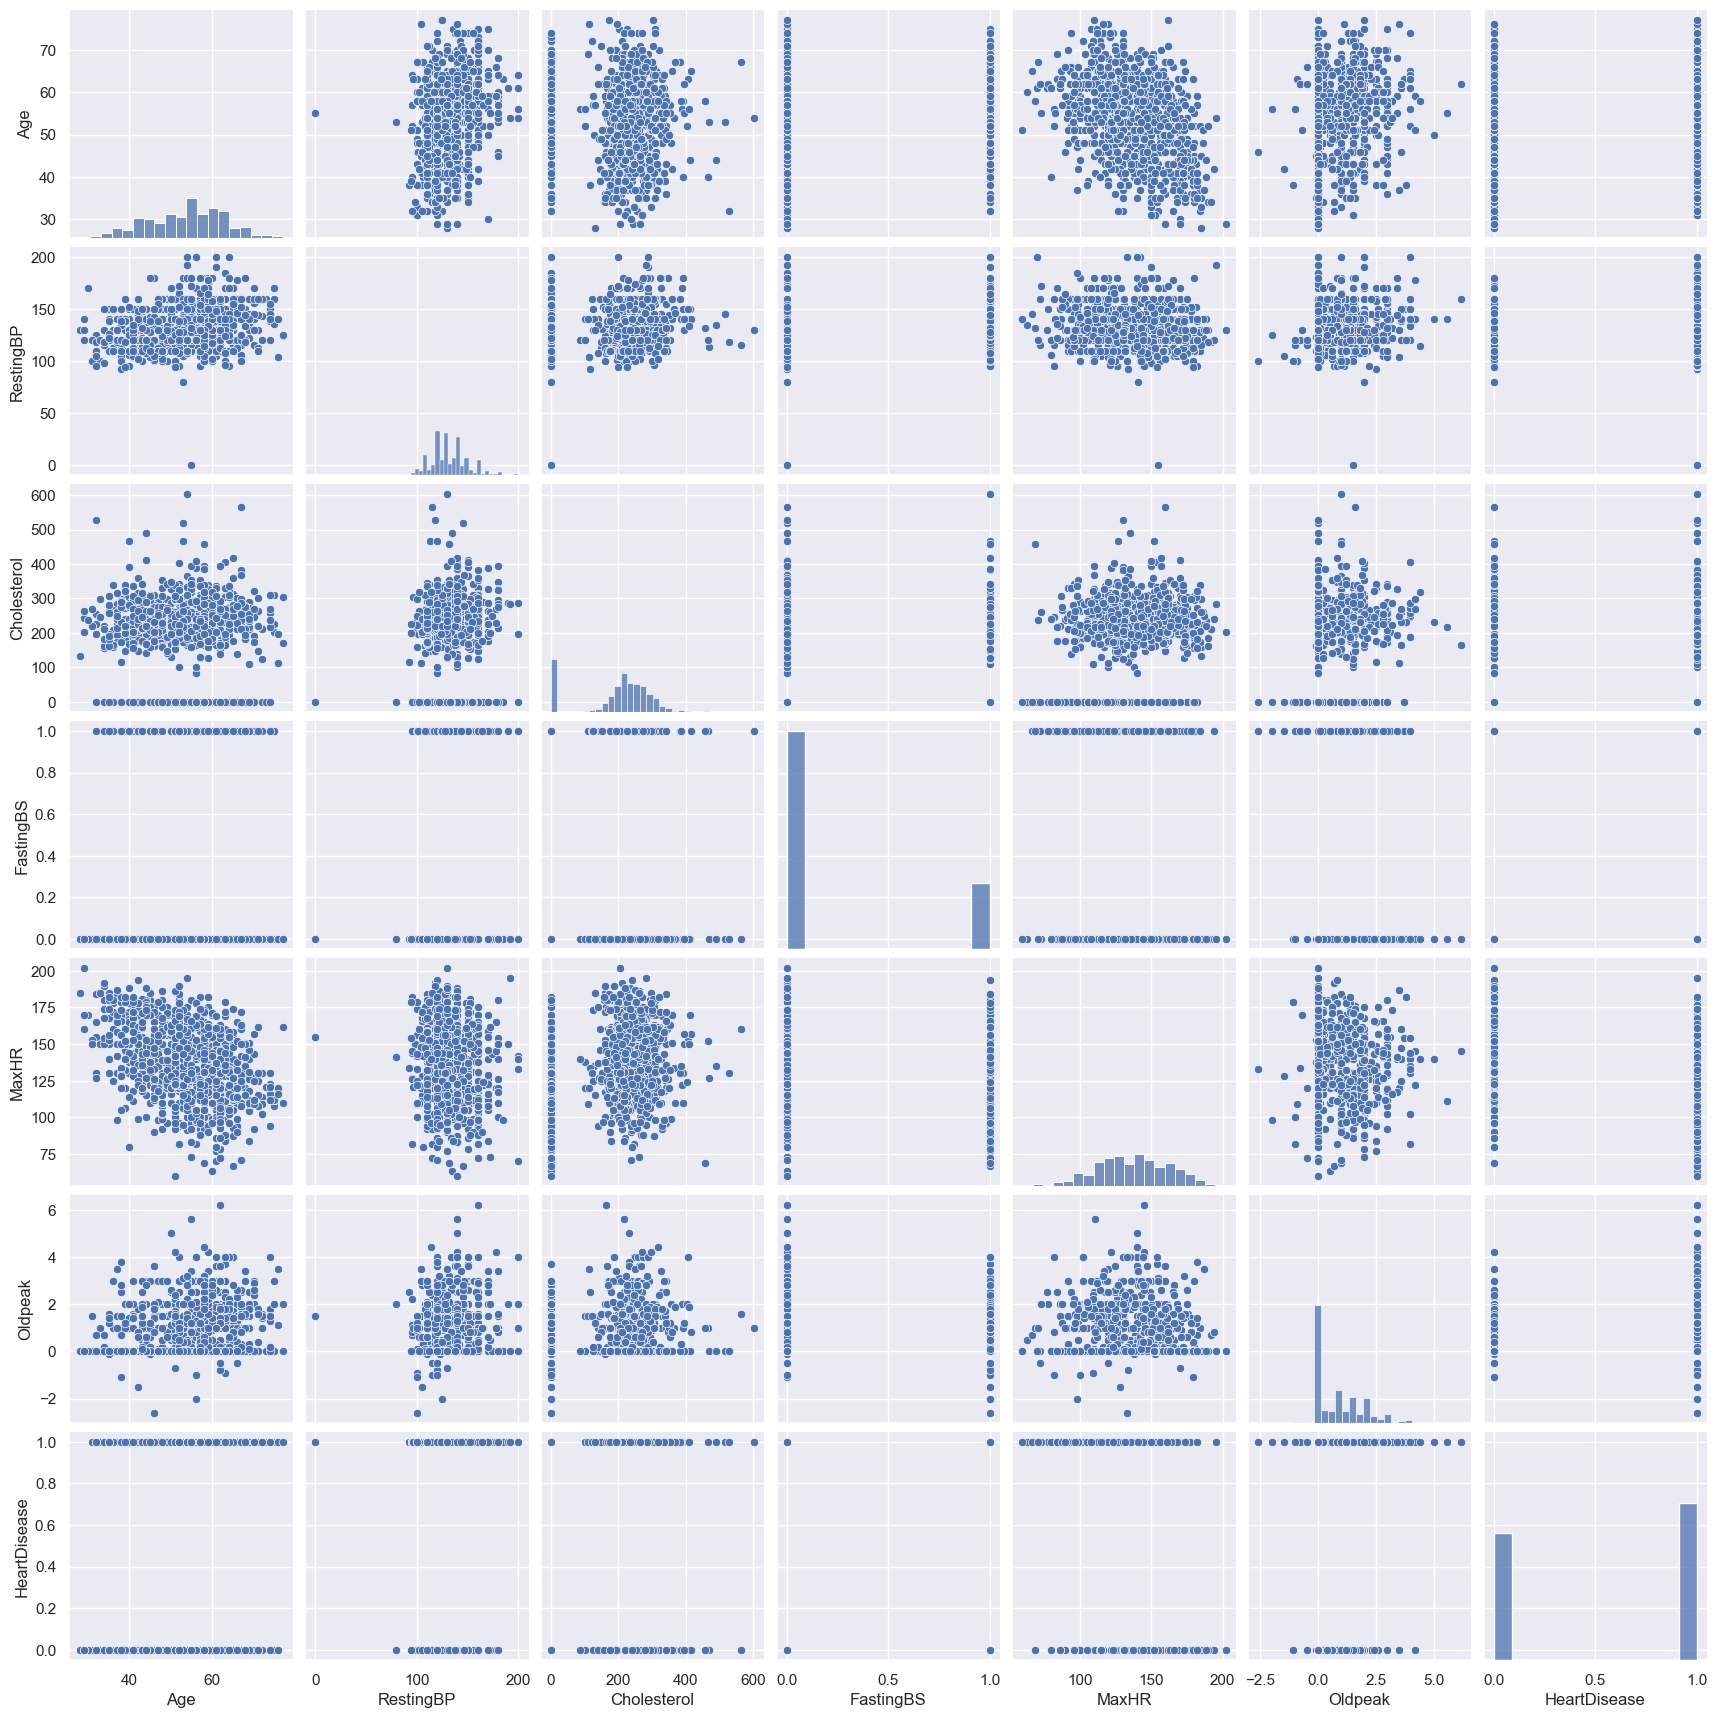

In [990]:
import seaborn as sns

sns.pairplot(df)
plt.show()

In [991]:
corr = df.loc[:, df.columns != "classification"].corr()
corr

C:\Users\HP\AppData\Local\Temp\ipykernel_22676\1862120142.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.loc[:, df.columns != "classification"].corr()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.264971,-0.095349,0.197809,-0.381275,0.259425,0.281808
RestingBP,0.264971,1.000000,0.099742,0.073177,-0.112663,0.170731,0.112631
Cholesterol,-0.095349,0.099742,1.000000,-0.260974,0.241065,0.050382,-0.232741
FastingBS,0.197809,0.073177,-0.260974,1.000000,-0.129490,0.052590,0.267291
MaxHR,-0.381275,-0.112663,0.241065,-0.129490,1.000000,-0.158650,-0.398388
Oldpeak,0.259425,0.170731,0.050382,0.052590,-0.158650,1.000000,0.404410
HeartDisease,0.281808,0.112631,-0.232741,0.267291,-0.398388,0.404410,1.000000


Największą korelację mamy między MaxHR i Age oraz Oldpeak i HeartDisease.

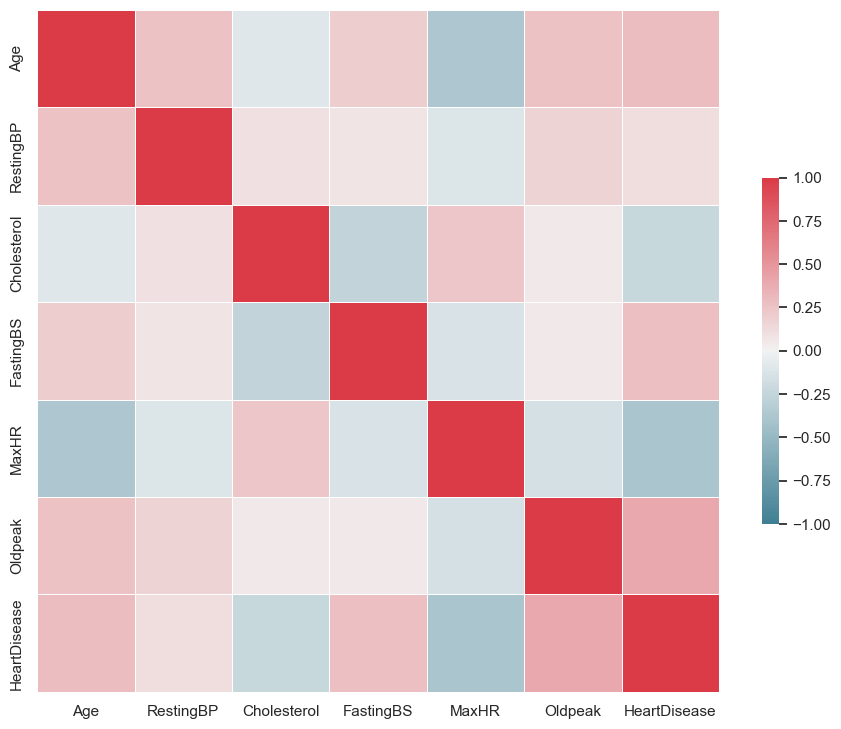

In [992]:
sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

In [993]:
df['Cholesterol'].value_counts()

0      172
254     11
223     10
220     10
230      9
      ... 
392      1
316      1
153      1
466      1
131      1
Name: Cholesterol, Length: 222, dtype: int64

In [994]:
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55.0,M,NAP,0.0,0,0,Normal,155.0,N,1.5,Flat,1


Ponieważ cholesterol ma aż 172 rekordy z nieprawidłową wartością (0), to usuwamy całą kolumnę ze zbioru danych. W przypadku RestingBP jest tylko jedna taka wartość, więc zmieniamy ją na medianę.

In [995]:
X = df.drop(['Cholesterol'], axis=1)

In [996]:
median_value = df['RestingBP'].median()
df['RestingBP'] = np.where(df['RestingBP'] == 0, median_value, df['RestingBP'])

In [997]:
print((df['RestingBP'] == 0).sum())
print((df['Age'] == 0).sum())
print((df['MaxHR'] == 0).sum())

0
0
0


Oldpeak może być równy 0, zatem nie ma już więcej niepoprawnych wartości numerycznych.

# Modelowanie danych

In [998]:
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease'].values

In [999]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.70, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.20)


Rzućmy okiem na atrybuty kategotyczne:

In [1000]:
X_train['Sex'].value_counts()

M    495
F    147
Name: Sex, dtype: int64

In [1001]:
X_train['ChestPainType'].value_counts()

ASY    353
NAP    137
ATA    121
TA      27
Name: ChestPainType, dtype: int64

In [1002]:
X_train['FastingBS'].value_counts()

0    503
1    139
Name: FastingBS, dtype: int64

In [1003]:
X_train['RestingECG'].value_counts()

Normal    384
LVH       131
ST        126
Name: RestingECG, dtype: int64

In [1004]:
X_train['ExerciseAngina'].value_counts()

N    380
Y    262
Name: ExerciseAngina, dtype: int64

In [1005]:
X_train['ST_Slope'].value_counts()

Flat    329
Up      273
Down     39
Name: ST_Slope, dtype: int64

Zbudujmy pipeline preprocessingu:

In [1006]:
from sklearn.base import BaseEstimator, TransformerMixin
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Pipeline dla atrybutów numerycznych. W miejsce pustych wartości wstawiamy medianę z danej kolumny.

In [1007]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(['RestingBP', 'Age', 'MaxHR', 'Oldpeak'])),
    ("imputer", SimpleImputer(strategy="median")),
])

Pipeline dla atrybutów kategorycznych. W miejsce pustej wartości wstawiamy najczęściej występującą wartość z danej kolumny oraz używamy kodowania one hot.

In [1008]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [1009]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

Pierwszy z modeli, który weźmiemy pod uwagę to Random Forest. Będziemy używać GridSearcha, aby znaleźć najlepsze parametry.

In [1010]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [1011]:
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', RandomForestClassifier())])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [6, 7, 8],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__random_state': [0]
}


In [1012]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

grid_search1 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search1.fit(X_train, y_train)
grid_search1.best_params_
ypred = grid_search1.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1013]:
print("Accuracy: ", accuracy)

Accuracy:  0.9285714285714286


<Axes: >

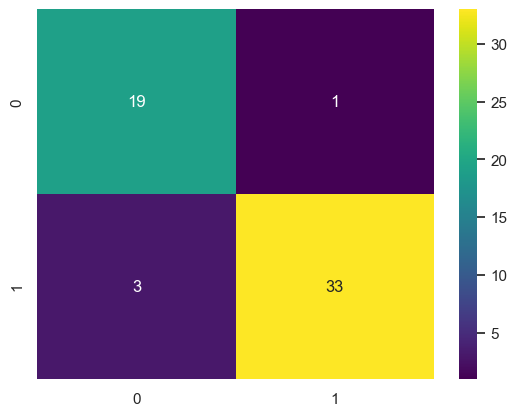

In [1014]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

SVM z jądrem rbf:

In [1015]:
from sklearn.svm import SVC

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', SVC(kernel='rbf'))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10 ,100, 1000],
}

In [1016]:
grid_search2 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search2.fit(X_train, y_train)
grid_search2.best_params_
ypred = grid_search2.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1017]:
print("Accuracy: ", accuracy)

Accuracy:  0.9107142857142857


<Axes: >

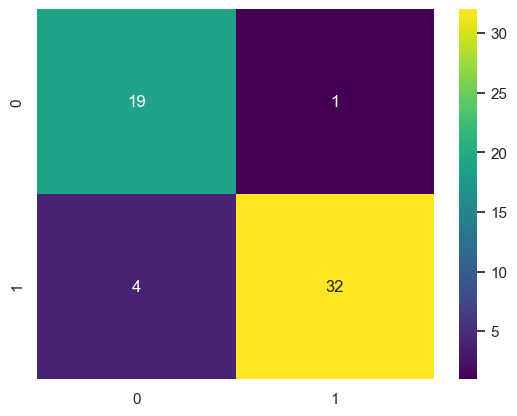

In [1018]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

SVM z jądem poly:

In [1019]:
from sklearn.svm import SVC

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', SVC(kernel='poly'))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10 ,100, 1000],
}

In [1020]:
grid_search3 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search3.fit(X_train, y_train)
grid_search3.best_params_
ypred = grid_search3.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1021]:
print("Accuracy: ", accuracy)

Accuracy:  0.9107142857142857


<Axes: >

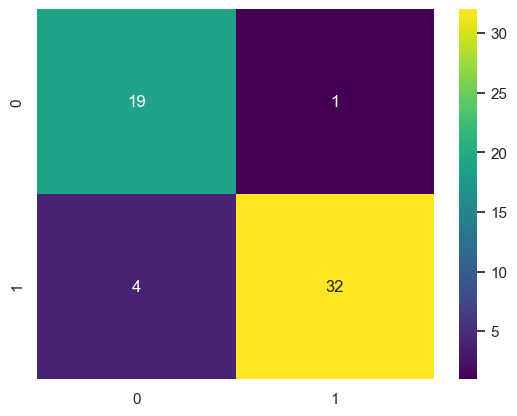

In [1022]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

SVM z jądrem linear:

In [1023]:
from sklearn.svm import SVC

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', SVC(kernel='linear'))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10 ,100, 1000]
}

In [1024]:
grid_search5 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search5.fit(X_train, y_train)
grid_search5.best_params_
ypred = grid_search5.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1025]:
print("Accuracy: ", accuracy)

Accuracy:  0.9107142857142857


<Axes: >

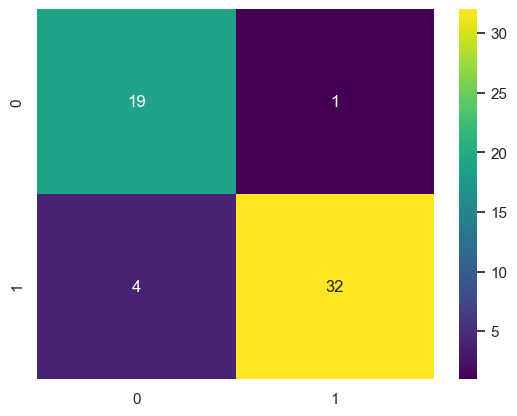

In [1026]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

Regresja logistyczna:

In [1027]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', LogisticRegression(n_jobs=-1))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

In [1028]:
grid_search6 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search6.fit(X_train, y_train)
grid_search6.best_params_
ypred = grid_search6.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<Axes: >

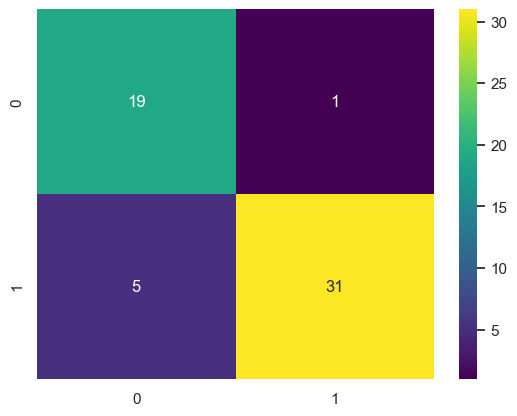

In [1029]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

XGBClassifier:

In [1030]:
import xgboost

pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('classifier', xgboost.XGBClassifier())])

param_grid = {
    'classifier__n_estimators': [2, 5, 10, 20],
    'classifier__learning_rate': [0.5, 1, 0.1, 2]
}

In [1031]:
grid_search4 = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search4.fit(X_train, y_train)
grid_search4.best_params_
ypred = grid_search4.predict(X_test)
accuracy = accuracy_score(y_test, ypred)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1032]:
print("Accuracy: ", accuracy)

Accuracy:  0.8392857142857143


<Axes: >

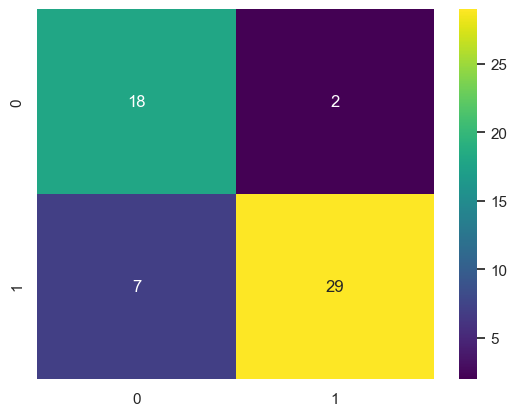

In [1033]:
conf_mat = confusion_matrix(y_test, ypred)
sns.heatmap(conf_mat, annot = True, cmap = 'viridis')

Porównanie wyników.

In [1034]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score


models = []
models.append(('RandomForest', grid_search1.best_estimator_))
models.append(('SVM rbf', grid_search2.best_estimator_))
models.append(('SVM poly', grid_search3.best_estimator_))
models.append(('SVM linear', grid_search5.best_estimator_))
models.append(('XGBoost', grid_search4.best_estimator_))
models.append(('Logistic Regression', grid_search6.best_estimator_))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_score = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    print("roc_score: {}".format( roc_auc_score(y_test, model.predict(X_test))))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
    roc_score.append(roc_auc_score(y_test, model.predict(X_test)))

RandomForest
R^2: 0.9705882352941176
recall_score: 0.9166666666666666
f1_score: 0.9428571428571428
accuracy_score: 0.9285714285714286
roc_score: 0.9333333333333332
SVM rbf
R^2: 0.9696969696969697
recall_score: 0.8888888888888888
f1_score: 0.927536231884058
accuracy_score: 0.9107142857142857
roc_score: 0.9194444444444444
SVM poly
R^2: 0.9696969696969697
recall_score: 0.8888888888888888
f1_score: 0.927536231884058
accuracy_score: 0.9107142857142857
roc_score: 0.9194444444444444
SVM linear
R^2: 0.9696969696969697
recall_score: 0.8888888888888888
f1_score: 0.927536231884058
accuracy_score: 0.9107142857142857
roc_score: 0.9194444444444444
XGBoost
R^2: 0.9354838709677419
recall_score: 0.8055555555555556
f1_score: 0.8656716417910448
accuracy_score: 0.8392857142857143
roc_score: 0.8527777777777777
Logistic Regression
R^2: 0.96875
recall_score: 0.8611111111111112
f1_score: 0.911764705882353
accuracy_score: 0.8928571428571429
roc_score: 0.9055555555555556


In [1035]:
d = {
    'method': ['RandomForest', 'SVM rbf', 'SVM poly', 'SVM linear', 'XGBoost', 'Logistic Regression'],
    'precision score': precision_score,
    'recall score': recall_score,
    'f1 score': f1_score,
    'accuracy score': accuracy_score,
    'roc score': roc_score 
}

df = pd.DataFrame(data=d)
df

,method,precision score,recall score,f1 score,accuracy score,roc score
0,RandomForest,0.970588,0.916667,0.942857,0.928571,0.933333
1,SVM rbf,0.969697,0.888889,0.927536,0.910714,0.919444
2,SVM poly,0.969697,0.888889,0.927536,0.910714,0.919444
3,SVM linear,0.969697,0.888889,0.927536,0.910714,0.919444
4,XGBoost,0.935484,0.805556,0.865672,0.839286,0.852778
5,Logistic Regression,0.968750,0.861111,0.911765,0.892857,0.905556


Porównanie współczynników liniowych SVMa liniowego i regresji logistycznej.

In [1036]:
cat_features = grid_search6.best_estimator_.named_steps["preprocessing"].transformer_list[1][1].named_steps['cat_encoder'].get_feature_names_out()
num_features = grid_search6.best_estimator_.named_steps["preprocessing"].transformer_list[0][1].named_steps['select_numeric'].attribute_names

In [1037]:
combined_features = np.concatenate([num_features, cat_features])

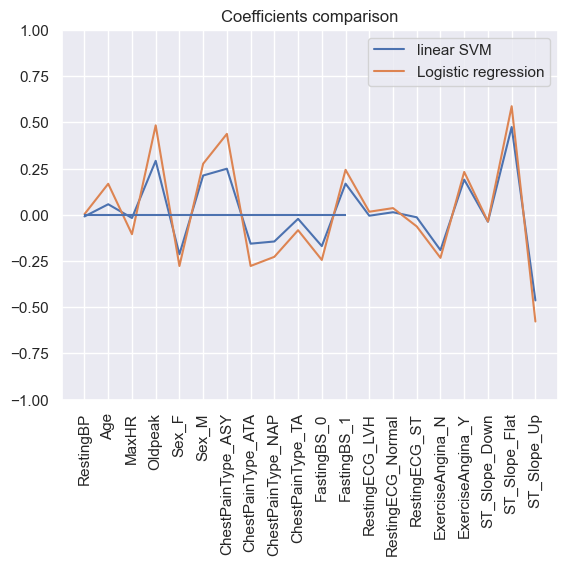

In [1038]:
plt.plot(grid_search5.best_estimator_.named_steps["classifier"].coef_.T, label="linear SVM")
plt.plot(grid_search6.best_estimator_.named_steps["classifier"].coef_.T, label="Logistic regression")
plt.xticks(range(combined_features.shape[0]), combined_features, rotation=90)
plt.hlines(0, 0, X_train.shape[1])
plt.ylim(-1, 1)
plt.legend()
plt.title("Coefficients comparison")
plt.show()

Porównanie feature importance dla XBGClassifier i Random Forest Classifier.

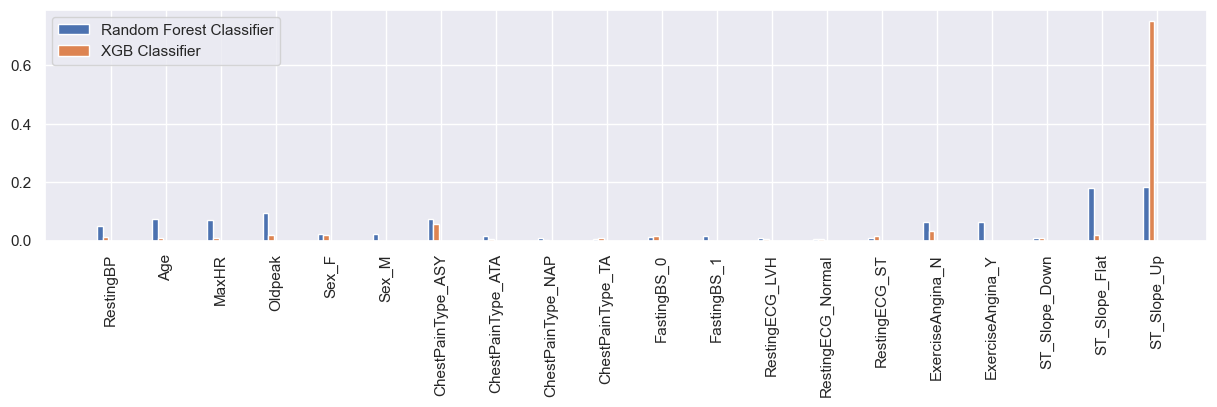

In [1039]:

fig, ax = plt.subplots(figsize=(15,3))
x = np.arange(len(combined_features))

ax.bar(x-0.2, grid_search1.best_estimator_.named_steps["classifier"].feature_importances_, width=0.1, align='center', label="Random Forest Classifier")
ax.bar(x-0.1, grid_search4.best_estimator_.named_steps["classifier"].feature_importances_, width=0.1, align='center', label="XGB Classifier")

plt.xticks(x, combined_features, rotation=90)
plt.legend()
plt.show()

Widać więc, że dla obu tych klasyfikatorów najważniejszym aspektem jest ST_Slope_UP.

# Sieci neuronowe

In [1040]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Activation
from keras.callbacks import History

In [1041]:
history = History()
model = Sequential()
model.add(Dense(32,activation="relu", input_shape=(20,)))
model.add(Dense(24,activation="relu"))
model.add(Dense(24,activation="relu"))
model.add(Dense(24,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_134 (Dense)           (None, 32)                672       
                                                                 
 dense_135 (Dense)           (None, 24)                792       
                                                                 
 dense_136 (Dense)           (None, 24)                600       
                                                                 


 dense_137 (Dense)           (None, 24)                600       
                                                                 
 dense_138 (Dense)           (None, 1)                 25        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [1042]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["binary_accuracy"])
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [1043]:
pipe = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('model', model)])

In [1044]:
preprocess_pipeline.fit(X_valid)
X_valid_transformed = preprocess_pipeline.transform(X_valid)
scaler = StandardScaler()
scaler.fit(X_valid_transformed)
X_valid_scaled_transformed = scaler.transform(X_valid_transformed)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1045]:

pipe.fit(X_train, y_train, model__validation_split=0.3, model__batch_size=32, model__epochs=100, model__callbacks=[early_stopper])

Epoch 1/100


c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


15/15 [==============================] - 1s 21ms/step - loss: 0.6824 - binary_accuracy: 0.6125 - val_loss: 0.6614 - val_binary_accuracy: 0.6788
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6096 - binary_accuracy: 0.7595 - val_loss: 0.6048 - val_binary_accuracy: 0.7254
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5415 - binary_accuracy: 0.8241 - val_loss: 0.5383 - val_binary_accuracy: 0.7979
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.4682 - binary_accuracy: 0.8307 - val_loss: 0.4749 - val_binary_accuracy: 0.8031
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.4005 - binary_accuracy: 0.8486 - val_loss: 0.4378 - val_binary_accuracy: 0.8187
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3672 - binary_accuracy: 0.8575 - val_loss: 0.4235 - val_binary_accuracy: 0.8342
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3504 -

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('num_pipeline',
                                                 Pipeline(steps=[('select_numeric',
                                                                  DataFrameSelector(attribute_names=['RestingBP',
                                                                                                     'Age',
                                                                                                     'MaxHR',
                                                                                                     'Oldpeak'])),
                                                                 ('imputer',
                                                                  SimpleImputer(strategy='median'))])),
                                                ('cat_pipeline',
                                                 Pipeline(steps=[('select_cat',
                                                                  DataFrameSelector(attribute_names=['Sex',
                                                                                                     'ChestPainType',
                                                                                                     'FastingBS',
                                                                                                     'RestingECG',
                                                                                                     'ExerciseAngina',
                                                                                                     'ST_Slope'])),
                                                                 ('imputer',
                                                                  MostFrequentImputer()),
                                                                 ('cat_encoder',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse=False,
                                                                                sparse_output=False))]))])),
                ('scale', StandardScaler()),
                ('model',
                 <keras.engine.sequential.Sequential object at 0x0000022F107D6D90>)])

In [1046]:
history = pipe.named_steps['model'].history

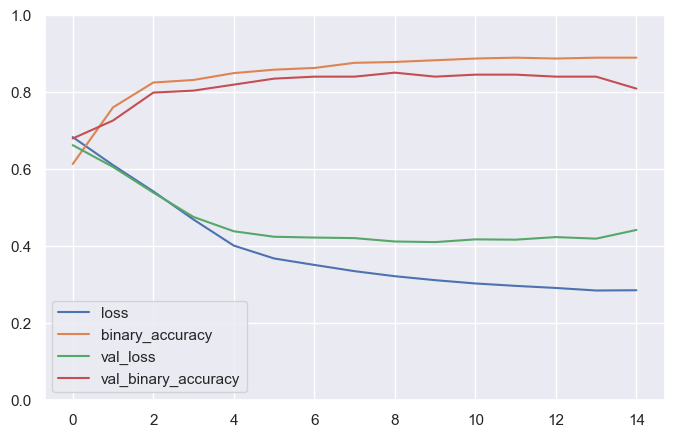

In [1047]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Teraz dodamy do tego modelu na każdej warstwie
```python
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))

In [1048]:
from keras.layers import Dropout

history1 = History()
model1 = Sequential()
model1.add(Dense(24,activation="relu", input_shape=(20,)))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Dropout(0.3))
model1.add(Dense(24,activation="relu"))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Dropout(0.3))
model1.add(Dense(24,activation="relu"))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation="sigmoid"))
model1.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_139 (Dense)           (None, 24)                504       
                                                                 
 batch_normalization_33 (Bat  (None, 24)               96        
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 24)                0         
                                                                 
 dropout_33 (Dropout)        (None, 24)                0         
                                                                 
 dense_140 (Dense)           (None, 24)                600       
                                                                 
 batch_normalization_34 (Bat  (None, 24)               96        
 chNormalization)                                    

In [1049]:
model1.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["binary_accuracy"])
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [1050]:
pipe1 = Pipeline([
        ('preprocessing', preprocess_pipeline),
        ('scale', StandardScaler()),
        ('model1', model1)])

In [ ]:
pipe1.fit(X_train, y_train, model1__validation_split=0.3, model1__batch_size=32, model1__epochs=100, model1__callbacks=[early_stopper])

In [1052]:
history1 = pipe1.named_steps['model1'].history

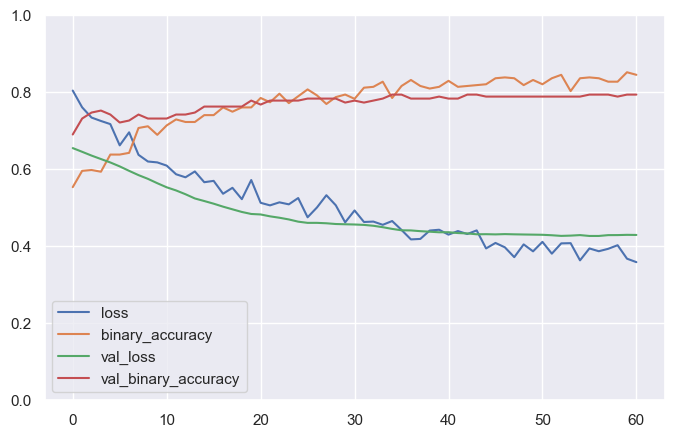

In [1053]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [1054]:
preprocess_pipeline.fit(X_test)
X_test_transformed = preprocess_pipeline.transform(X_test)
scaler = StandardScaler()
scaler.fit(X_test_transformed)
X_test_scaled_transformed = scaler.transform(X_test_transformed)

test_preds = model.predict(X_test_scaled_transformed)
test_preds = [1.0 if i > 0.5 else 0.0 for i in test_preds]

test_preds1 = model1.predict(X_test_scaled_transformed)
test_preds1 = [1.0 if i > 0.5 else 0.0 for i in test_preds1]

print(model.evaluate(X_test_scaled_transformed, y_test))
print("precision: {}".format(metrics.precision_score(y_test, test_preds) ))
print("recall_score: {}".format( metrics.recall_score(y_test, test_preds) ))
print("f1_score: {}".format( metrics.f1_score(y_test, test_preds) ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, test_preds)) )
print("roc_score: {}".format( roc_auc_score(y_test, test_preds)))

2/2 [==============================] - 0s 2ms/step


c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2/2 [==============================] - 0s 4ms/step - loss: 0.2889 - binary_accuracy: 0.8929
[0.28893813490867615, 0.8928571343421936]
precision: 0.96875
recall_score: 0.8611111111111112
f1_score: 0.911764705882353
accuracy_score: 0.8928571428571429
roc_score: 0.9055555555555556


In [1055]:
print(model1.evaluate(X_test_scaled_transformed, y_test))
print("precision: {}".format(metrics.precision_score(y_test, test_preds1) ))
print("recall_score: {}".format( metrics.recall_score(y_test, test_preds1) ))
print("f1_score: {}".format( metrics.f1_score(y_test, test_preds1) ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, test_preds1)) )
print("roc_score: {}".format( roc_auc_score(y_test, test_preds1)))

2/2 [==============================] - 0s 4ms/step - loss: 0.2929 - binary_accuracy: 0.9643
[0.2929403483867645, 0.9642857313156128]
precision: 0.9722222222222222
recall_score: 0.9722222222222222
f1_score: 0.9722222222222222
accuracy_score: 0.9642857142857143
roc_score: 0.9611111111111111


In [1056]:
precision_score.append(metrics.precision_score(y_test, test_preds))
recall_score.append(metrics.recall_score(y_test,test_preds))
f1_score.append( metrics.f1_score(y_test, test_preds))
accuracy_score.append(metrics.accuracy_score(y_test, test_preds))
roc_score.append(roc_auc_score(y_test, test_preds))

precision_score.append(metrics.precision_score(y_test, test_preds1))
recall_score.append(metrics.recall_score(y_test,test_preds1))
f1_score.append( metrics.f1_score(y_test, test_preds1))
accuracy_score.append(metrics.accuracy_score(y_test, test_preds1))
roc_score.append(roc_auc_score(y_test, test_preds1))

In [1057]:
d = {
    'method': ['RandomForest', 'SVM rbf', 'SVM poly', 'SVM linear', 'XGBoost', 'Logistic Regression', 'Neural Network 1', 'Neural Network 2'],
    'precision score': precision_score,
    'recall score': recall_score,
    'f1 score': f1_score,
    'accuracy score': accuracy_score,
    'roc score': roc_score 
}

df = pd.DataFrame(data=d)
df

,method,precision score,recall score,f1 score,accuracy score,roc score
0,RandomForest,0.970588,0.916667,0.942857,0.928571,0.933333
1,SVM rbf,0.969697,0.888889,0.927536,0.910714,0.919444
2,SVM poly,0.969697,0.888889,0.927536,0.910714,0.919444
3,SVM linear,0.969697,0.888889,0.927536,0.910714,0.919444
4,XGBoost,0.935484,0.805556,0.865672,0.839286,0.852778
5,Logistic Regression,0.968750,0.861111,0.911765,0.892857,0.905556
6,Neural Network 1,0.968750,0.861111,0.911765,0.892857,0.905556
7,Neural Network 2,0.972222,0.972222,0.972222,0.964286,0.961111


# Podsumowanie

Z wszystkich modeli najlepiej sprawuje się druga sieć neuronowa.